# NNTuck code tutorial
In this notebook we document a simple example of finding the NNTuck of the adjacency tensor for the multilayer network of 'Village 4' from The Diffusion of Microfinance work.

This notebook depends on `numpy`, `tensorly`, `sklearn`, and `matplotlib`. When sweeping over parameters $K$ and $C$ in NNTuck it is most efficient to run the sweep in parallel, which depends on `joblib` and on `os` to make sure the parallel runs don't use too much CPU. In this tutorial we only sweep over one possible combination of parameters $(K,C)$, but the code is still written in parallel to easily adapt for a more comprehensive sweep. Specific version numbers for which this code runs are in the readme.

The NNTuck multiplicative updates are in `NNTucktools.py` along with definitions of KL-divergence and log-likelihood.

Masking tools are in `masking_tools_*.py` and `masking_tools_*_chunks.py` where `*` is replaced by either `directed` or `undirected` depending on the network type. The files labeled `chunks` mask the adjacency tensor using the rules of the tubular link prediction task, whereas the others mask using the rules of the iid link prediction task. Formal definitions of each task can be found in the main manuscript. 
These files also include definitions for `Per_alpha`, `Per_alpha_c`, and `Per_alpha_ones`. Each of these definitions assists in the parallel sweep over $K$ and $C$ when estimating the NNTuck for the network, and does so for an NNTuck with $C=\alpha$, $\boldsymbol{Y} = \boldsymbol{I}$, and $\boldsymbol{Y} = [1, \dots, 1]^\top$, respectively, each corresponding to a deflated NNTuck of dimension $\alpha$, a constrained NNTuck with a layer-independence assumption, and a constrained NNTuck with a layer-redundance assumption. Again, for more information on each of these model assumptions see the main manuscript.

For this example, we use a directed village multilayer network and an iid masking tensor. We provide code for sweeping over parameter values $(K,C)$. We also show how, after a pair of parameters have been chosen, one can estimate the NNTuck using the full (unmasked) network, and show how the $\boldsymbol{Y}$ masking tensor can be interpreted.

Please email me at `izzya@stanford.edu` with ANY questions at all about this tutorial or the code associated with it!

### Import libraries and external definitions

In [1]:
import os

#------ Make sure parallel runs don't use too much CPU --------#
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

#------ Import Libraries --------#
import numpy as np
from NNTucktools import non_negative_tucker, non_negative_tucker_ones, KL_D, max_like, Y_interp, LRT
    #this .py file contains function definitions for non_negative_tucker with KL loss
import tensorly as tl
from sklearn.metrics import roc_auc_score
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.base import unfold
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed, parallel_backend
from matplotlib.ticker import MaxNLocator
from masking_tools_directed import Per_alpha, Per_alpha_c, masking_tensor, Per_alpha_ones
from masking_tools_directed_chunks import Per_alpha, Per_alpha_c, masking_tensor_chunks, Per_alpha_ones
import copy

### Load the adjacency tensor
We load the adjacency tensor for the zeroth village from the [Banerjee et al. Diffusion of Microfinance dataset](https://web.stanford.edu/~jacksonm/Data.html). We use the network defined on the individual level (as opposed to household). The `BigVillsIND.npy` file contains adjacency tensors defined on the individual level for all 43 villages. We only consider the subset of the nodes who have at least one outgoing or inoming edge, in any layer. In this village, that means subsetting all but two nodes who are not connected to anybody, in any layer.

In [2]:
BigVillsIND = np.load('BigVillsIND.npy', allow_pickle = True)
V = 4 #Change this to any number in [0, 42] if you want to use a different village
tensor = np.array([BigVillsIND[V][1:][i] for i in range(len(BigVillsIND[V][1:]))])
layers = [
    'Those from whom the respondent would borrow money',
    'Those to whom the respondent gives advice',
    'Those from whom the respondent gets advice',
    'Those from whom the respondent would borrow material goods',
    'Those to whom the respondent would lend material goods',
    'Those to whom the respondent would lend money',
    'Those from whom the respondent receives medical advice',
    'Non-relatives with whom the respondent socializes',
    'Kin in the village',
    'Those whom the respondent goes to pray with',
    'Those who visit the respondents home',
    'Those whose homes the respondent visits'
]
layers_short = [
    'Borrow money',
    'Gives advice',
    'Gets advice',
    'Borrow material goods',
    'Lend material goods',
    'Lend money',
    'Receives medical advice',
    'Socializes with',
    'Kin',
    'Prays with',
    'Visit here',
    'Visit there'
]
b= np.sum(tensor, axis = 0)
c = np.sum(b, axis = 0)
nonzero_conn = np.where(c != 0)[0]
tensor_nz = tensor[:, nonzero_conn, :]
tensor_nz = tensor_nz[:, :, nonzero_conn]

### Visualise the network

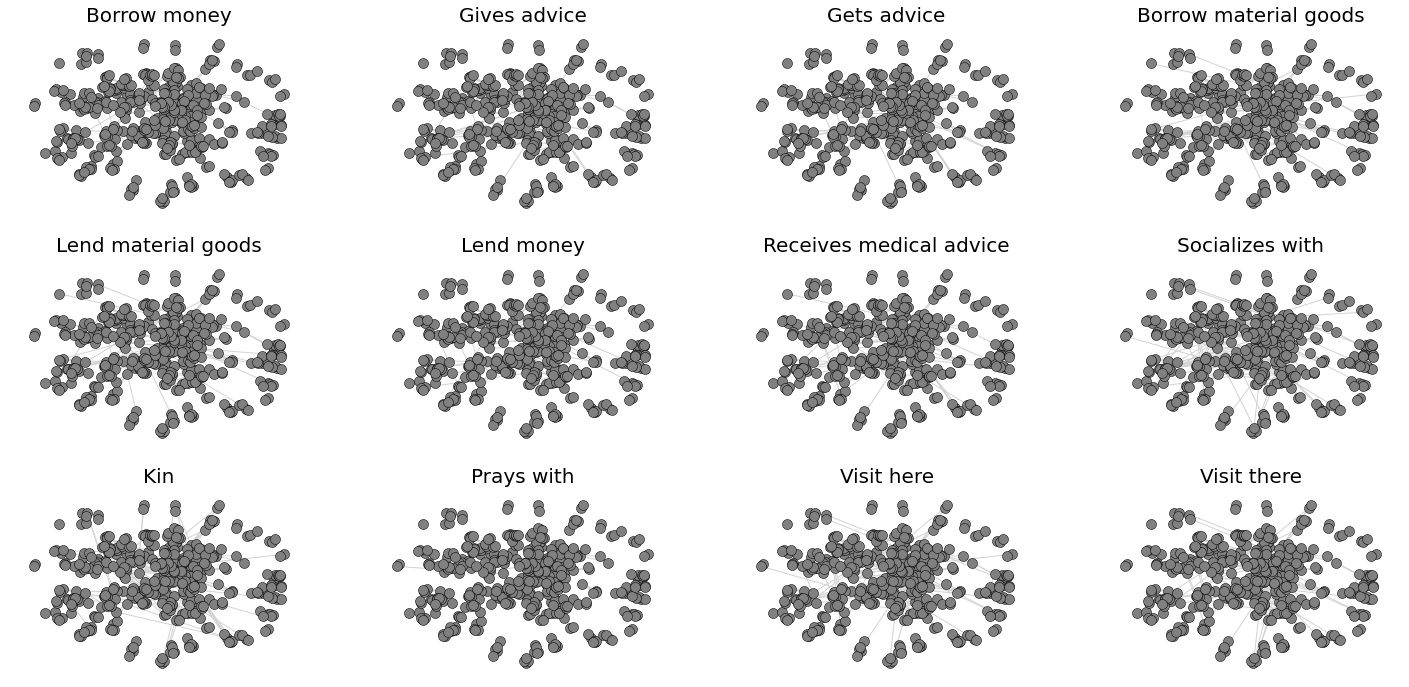

In [52]:
save_image = False
from matplotlib import cm
import networkx as nx
ALPHA, N, N = np.shape(tensor_nz)
tensor_Network = nx.from_numpy_matrix(tensor_nz[0])
pos = nx.spring_layout(tensor_Network, k=0.1)
rows = int(np.ceil(ALPHA/4))
f, axis = plt.subplots(rows, 4, figsize=(25,12))
for l in range(ALPHA):
    r = int(np.floor(l/(rows+1)))
    c = int(l%4)
    tensor_Network = nx.from_numpy_matrix(tensor_nz[l])
    nx.draw(tensor_Network, pos, ax = axis[r, c], node_color='grey', node_size=100, edge_color='lightgrey', with_labels=False)
    ax = plt.gca() # to get the current axis
    axis[r, c].collections[0].set_edgecolor("k") 
    axis[r, c].collections[0].set_linewidths(0.5) 
    axis[r, c].set_title(layers_short[l], fontsize = 20)
    if save_image:
        filename = 'vill_network_layers.pdf'
        plt.savefig(filename)

### Estimating the NNTuck from the full multilayer network

Once the parameter pair $(K,C)$ has been selected (depending on interpretation of the parameter sweep and associated test-AUC), an NNTuck can be estimated from the full multilayer network, and the resulting factor matrices can be interpreted. 

Here, we show an example with $K= 4$ and $C = 2$

We find the NNTuck corresponding to the maximal log-likelihood over `NUM_IT = 20` random initializations

In [53]:
ALPHA, N, N = np.shape(tensor)

In [54]:
C = 2
K = 4
NUM_IT = 20
tuck, logl, kld = non_negative_tucker(tensor_nz, rank = [C, K, K], init='random', n_iter_max=1000,
                                                         symmetric = False, masked = False, 
                                                  MT_stopping_conditions = True, returnErrors = True,
                                                    verbose=False, constrained=False, loss = 'KL', tol=10e-6)
max_logl = logl[-1]
max_tuck = tuck
max_kld = kld[-1]

for i in range(NUM_IT-1):
    tuck, logl, kld = non_negative_tucker(tensor_nz, rank = [C, K, K], init='random', n_iter_max=1000,
                                                         symmetric = False, masked = False, 
                                                  MT_stopping_conditions = True, returnErrors = True,
                                                    verbose=False, constrained=False, loss = 'KL', tol=10e-6)
    if logl[-1] > max_logl:
        print('old log like was {} now is {}'.format(max_logl, logl[-1]))
        max_logl = logl[-1]
        max_tuck = tuck
        max_kld = kld[-1]
        
core, factors = max_tuck

old log like was -105033.40559845872 now is -104109.40319735438
old log like was -104109.40319735438 now is -103520.39789133883


## Likelihood ratio tests
The function `LRT` from `NNTucktools` returns the p-value corresponding to the **layer independence test**, **layer dependence test**, or **layer redundance test**, specified by the `Type`parameter as one of `independent`, `dependent`, or `redundant`, respectively. The inputs to the function are the NNTuck of the full model, the NNTuck of the nested model, and the type of LRT. The boolean flag `Masked` indicates if the NNTuck was estimated with some of the data masked, and if so the corresponding masking matrix must be included so log-likelihood is calculated only over the unmasked entries. The function also returns the log-likelihood of the NNTuck for the full and nested models.

In [3]:
K = 4
nested_tuck, nested_logl, nested_kld = non_negative_tucker_ones(tensor_nz, rank = [1, K, K], init='random', n_iter_max=1000,
                                                         symmetric = False, masked = False, 
                                                  MT_stopping_conditions = True, returnErrors = True,
                                                    verbose=False, constrained=True, loss = 'KL', tol=10e-6)
full_tuck, full_logl, full_kld = non_negative_tucker(tensor_nz, rank = [12, K, K], init='random', n_iter_max=1000,
                                                         symmetric = False, masked = False, 
                                                  MT_stopping_conditions = True, returnErrors = True,
                                                    verbose=False, constrained=True, loss = 'KL', tol=10e-6)

p, full_ll, nest_ll = LRT(tensor_nz, full_tuck, nested_tuck, Type = 'redundant', Masked = False, M = None)


p-value of layer redundant test is 1.0


## Interpreting $\boldsymbol{Y}$
### Choosing the layer-basis for constructing $\boldsymbol{Y}^*$
If you'd like to interpret $\boldsymbol{Y}$ by constructing $\boldsymbol{Y}^*$, consider inspecting $\boldsymbol{Y}, \boldsymbol{Y}_{2-norm}\boldsymbol{Y}_{2-norm}^\top,$ and $\boldsymbol{Y}_{1-norm}$ first. All of these can aid in choosing a good layer basis for constructing $\boldsymbol{Y}^*$. To just consider these interpretations, run the following line of code.

True Y is 

[[0.0027 0.002 ]
 [0.003  0.0008]
 [0.0029 0.0012]
 [0.0008 0.0055]
 [0.0032 0.0012]
 [0.0033 0.0006]
 [0.0029 0.0015]
 [0.0026 0.0025]
 [0.0028 0.0012]
 [0.0022 0.0016]
 [0.0022 0.0031]
 [0.0028 0.0021]]

Y_norm is

[[0.5764 0.4236]
 [0.7789 0.2211]
 [0.7068 0.2932]
 [0.1214 0.8786]
 [0.7221 0.2779]
 [0.8465 0.1535]
 [0.652  0.348 ]
 [0.5076 0.4924]
 [0.7031 0.2969]
 [0.5761 0.4239]
 [0.4209 0.5791]
 [0.5731 0.4269]]



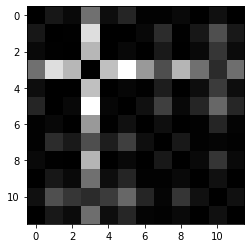

In [57]:
Y_interp(factors)

### Constructing $\boldsymbol{Y}^*$
After determining the layer basis, defined by `r_star`, the following lines of code will print $\boldsymbol{Y}^*$ along with the other oprtions for interpreting $\boldsymbol{Y}$.

True Y is 

[[0.0027 0.002 ]
 [0.003  0.0008]
 [0.0029 0.0012]
 [0.0008 0.0055]
 [0.0032 0.0012]
 [0.0033 0.0006]
 [0.0029 0.0015]
 [0.0026 0.0025]
 [0.0028 0.0012]
 [0.0022 0.0016]
 [0.0022 0.0031]
 [0.0028 0.0021]]

Y_norm is

[[0.5764 0.4236]
 [0.7789 0.2211]
 [0.7068 0.2932]
 [0.1214 0.8786]
 [0.7221 0.2779]
 [0.8465 0.1535]
 [0.652  0.348 ]
 [0.5076 0.4924]
 [0.7031 0.2969]
 [0.5761 0.4239]
 [0.4209 0.5791]
 [0.5731 0.4269]]

row normalized Y_star is

[[0.2697 0.7303]
 [0.0601 0.9399]
 [0.1292 0.8708]
 [1.     0.    ]
 [0.1141 0.8859]
 [0.     1.    ]
 [0.1857 0.8143]
 [0.3531 0.6469]
 [0.133  0.867 ]
 [0.27   0.73  ]
 [0.4692 0.5308]
 [0.2735 0.7265]]



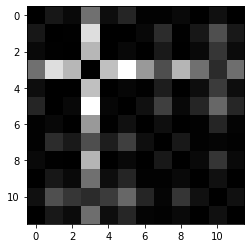

In [58]:
r_star = [3, 5] #r_star must be a list of length C
Y_interp(factors, True, r_star)

## Interpreting $\boldsymbol{U}$ (or $\boldsymbol{V}$)
The best way to interpret the $\boldsymbol{U}$ or $\boldsymbol{V}$ factor matrix is to visualize the network where each node as coloured by its relative membership to each of $K$ groups.

To visualize one edgeset for the multilayer network, use the `threshhold` parameter. Below, we plot the edges that occur in at least one of the layers. 

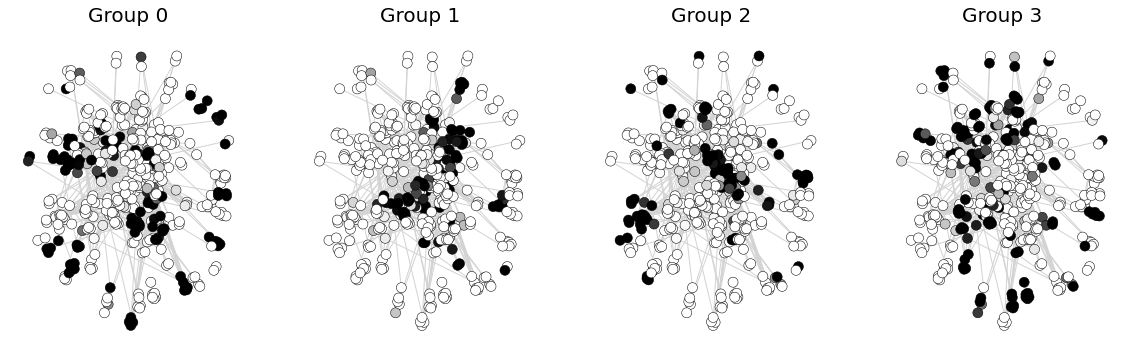

In [59]:
threshhold = 1
save_image = False

Y, U, V = factors
from matplotlib import cm
import networkx as nx
tensor_and = np.sum(tensor_nz, axis = 0)
tensor_and[np.where(tensor_and < threshhold)] = 0
tensor_and[np.where(tensor_and >= threshhold)] = 1
tensor_Network = nx.from_numpy_matrix(tensor_and)

f, axis = plt.subplots(K%4 + 1, 4, figsize=(20,6))
colors_U = ['c'] * len(tensor_and)
U_norm = U/np.sum(U, axis = 1, keepdims = True)
for j in range(K):
    for i in range(len(tensor_and)):
        colors_U[i] = cm.binary(U_norm[i, j])
    nx.draw(tensor_Network, pos, ax = axis[j], node_color=colors_U, node_size=100, edge_color='lightgrey', with_labels=False)
    ax = plt.gca() # to get the current axis
    axis[j].collections[0].set_edgecolor("k") 
    axis[j].collections[0].set_linewidths(0.5) 
    axis[j].set_title('Group {}'.format(j), fontsize = 20)
    if save_image:
        filename = 'vill_network_U_interp.pdf'
        plt.savefig(filename)

### Model selection $(K, C)$

This code generates five masking tensors where each one masks a different 20\% of the tensor according to the iid link prediction task setup. For each masking tensor, we estimate the corresponding NNTuck for each pair of parameter values $(K, C)$. 

For this example we set `K_max = max_ALPHA = 2` and thus only consider $K=2$ and $C=2$ to sweep over more values, set `K_max = 20` and `max_ALPHA = ALPHA`. Because the multiplicative updates use a random initialization for each factor matrix and for the core tensor, and because they only guarantee convergence to a _local_ maximum, the parameter `num_it` defines the number of random initializations to start from before the NNTuck with the maximal log-likelihood over those estimations is chosen. In the below code, `num_it` is only used to save the file. **If you want to change `num_it`, you must also change `NUM_IT` in the `masking_tools_directed.py` file.** Here, we set `num_it = 20`.

The results from this sweep will be saved in files `iid_RESULTS_Meq_bvill_N_Keq_K.npy` for `N=num_it` and `K` sweeping between 2 and 20 and in `iid_results_Meq_bvill_ones_N.npy`. Each `RESULTS` file is of size `(2,)` where `RESULTS[0]` is the `(1,5,4)` array corresponding to the layer independent NNTuck and `RESULTS[1]` is the `(Crange, 5, 4)` array corresponding to the layer dependent NNTuck for each C in the sweep. For masking `i` and `C=j`, `RESULTS[1][i][j][0]` is the train log-likelihood, `RESULTS[1][i][j][1]` is the KL-divergence on the train data, `RESULTS[1][i][j][2]` is the corresponding NNTuck, `RESULTS[1][i][j][3]` is the associated masking tensor.

To use the tubular link prediction task instead of the independent, change the `masking_tensor` function to `masking_tensor_chunks`.

In [4]:
num_it = 2
K_max = 2
max_ALPHA = 2
print("starting village ", V)
ALPHA, N, N = np.shape(tensor)
prefix = 'iid_RESULTS_Meq_bvill_'
prefix_ones = 'iid_RESULTS_Meq_bvill_ones'
qual = '_Keq'
i = 0
Maskings = masking_tensor(tensor)
for K in range(2, K_max+1):
    RESULTS_Ala = [] #will be 5 x ALPHA+1 where each entry will be (current_AUC, current_like, ten, M)
    print("starting K = {}".format(K))
    print("estimating the constrained NNTuck")
    C_Results = Parallel(n_jobs = 1)(delayed(Per_alpha_c)(tensor, K, Maskings) for c in range(ALPHA,ALPHA+1))
    RESULTS_Ala.append(C_Results)
    print("estimating the deflated NNTuck")
    C_Results = Parallel(n_jobs = 1)(delayed(Per_alpha)(tensor, c, K, Maskings) for c in range(1,max_ALPHA+1))
    RESULTS_Ala.append(C_Results)
    RESULTS_Ala = np.array(RESULTS_Ala, dtype=object)
    filename = prefix + str(num_it) + qual + str(K)
    np.save(filename, RESULTS_Ala)
    print('Done with K = {}'.format(K))

print("estimating the NNTuck with Y=ones")
C_Results_ones = Parallel(n_jobs = 1)(delayed(Per_alpha_ones)(tensor, K, Maskings) for K in range(2, K_max+1))
RESULTS_Ala_ones = np.array(C_Results_ones, dtype=object)
filename = prefix_ones + str(num_it)
np.save(filename, RESULTS_Ala_ones)

starting village  4
starting K = 2
estimating the constrained NNTuck
doing Y == I with K = 2
estimating the deflated NNTuck
doing c = 1 with K =2
doing c = 2 with K =2
Done with K = 2
estimating the NNTuck with Y=ones
K is  2


### Cross validation for model selection
Here we load in the results from a cross-validation sweep over both $C$ and $K$ for $C = 1, 
\dots, 12$ and $K = 2, \dots, 20$.

In [55]:
avg_KL_bvill4_iid = np.load('avg_KL_bvill4_iid.npy')
avg_bvill4_ones_KL = np.load('avg_bvill4_ones_KL.npy')

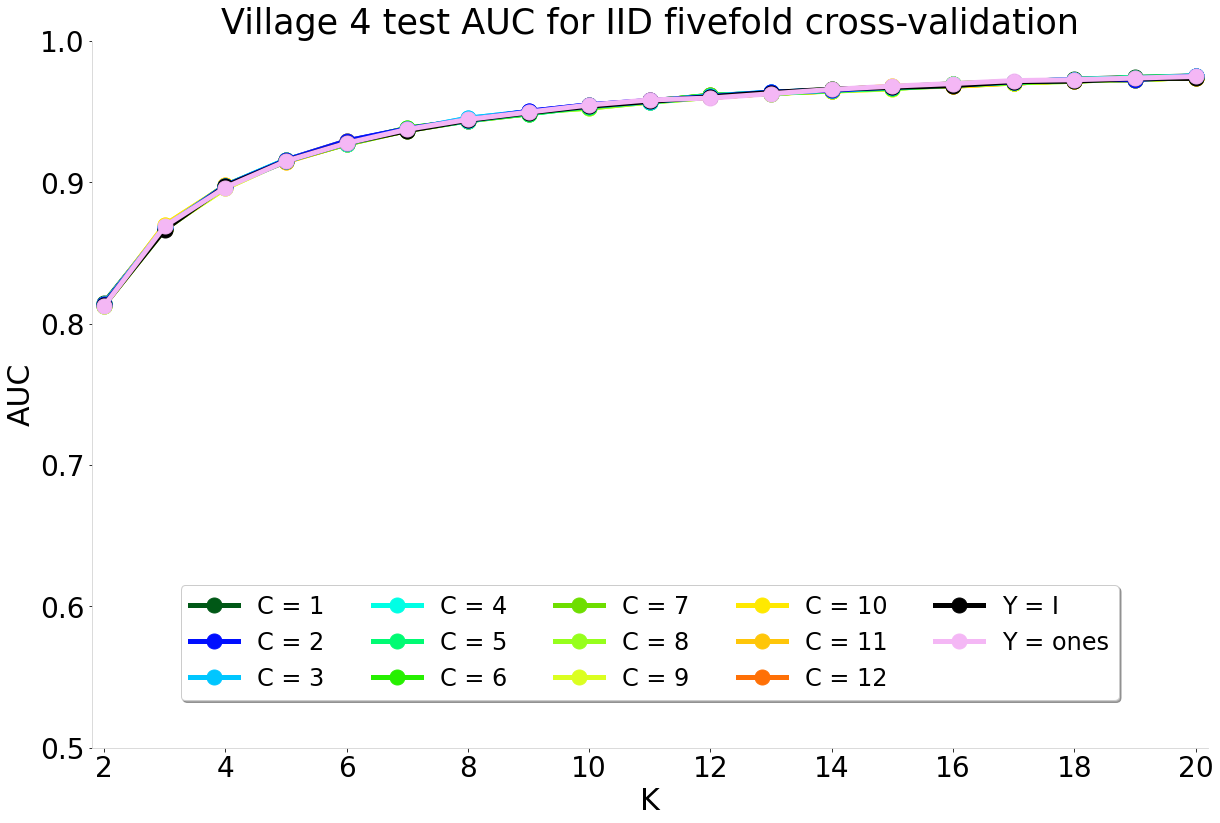

In [56]:
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 19)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for ell in range(1,13):
    col = colors[ell]
    axis.plot(range(2,21),avg_AUCs_bvill4_iid[:, ell], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell]))
for ell in range(12,1, -1):
    col = colors[ell]
    axis.plot(range(2,21),avg_AUCs_bvill4_iid[:, ell], lw = 5, marker='o', markersize= 15, c=col)

axis.plot(range(2,21),avg_AUCs_bvill4_iid[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.5, 1)
axis.set_xlim(1.8, 20.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,21), avg_bvill4_ones_AUC, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')

axis.legend(fontsize = 24, loc='lower center', bbox_to_anchor=(0.5, .05),
          ncol=5, fancybox=True, shadow=True)

axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Village 4 test AUC for IID fivefold cross-validation',fontsize=35)
plt.savefig('ala_sweep.pdf', pad_inches=0.05)